# Climate dynamics with stochasticity

This notebook contains a set of tools and procedures that are useful when exploring the zero-dimensional energy-balance model of Earth's climate. Feel free to edit, copy, paste, etc. as needed.

In [1]:
# Import relevant packages

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint    # for solving ODEs
from scipy.optimize import fsolve     # to find roots

### A zero-dimentional global energy-balance model including ice–albedo feedback

Here we construct the model according to the energy balance model
$$\begin{aligned}
C\,\frac{\mathop{}\!\mathrm{d}T}{\mathop{}\!\mathrm{d}t} &= \frac{S_0}{4}(1-a) - \varepsilon \sigma T^4 \\
\tau_a\,\frac{\mathop{}\!\mathrm{d}a}{\mathop{}\!\mathrm{d}t} &= - \bigl[a - a_{\text{eq}}(T)\bigr],
\end{aligned}$$
where the albedo is modeled as a smooth step between mostly ice and mostly water conditions:
$$
a_{\text{eq}}(T) = \frac{(a_\text{i}+a_\text{w})}{2} - \frac{(a_\text{i}-a_\text{w})}{2}\tanh\left(\frac{T-T_\text{c}}{w_T/2}\right).
$$

To add noise, you can use `np.random.randn()`. For random samples $\sim\mathcal{N}(\mu,\sigma^2)$ use `sigma * np.random.randn() + mu`.

In [2]:
# Define physical parameters

S0 = 1368.0       # W/m^2
T0 = 288.0        # Kelvin (reference temperature scale)
T_init = 240.0    # Kelvin (some initial condition)
a_init = 0.35     # initial condition for albedo
emissivity = 0.61 # so that Teq = 288 K
sigma = 5.67e-8   # W/(m^2 K^4)
beta = 5.0        # noise parameter
delta = 1e-2      # ratio of time scales tT/ta
year_to_sec = 3153600    # 1 year in seconds

In [3]:
# Define simulation parameters (set the time step, initialize arrays)

timesteps = 500  # Number of time steps
timepoints = np.linspace(0, 6, timesteps)    # in years
tempsteps = 350  # Number of temperature steps
temperature_range = np.linspace(200, 350, tempsteps)
albedo = np.zeros(tempsteps)
rad_incoming = np.zeros(tempsteps)
rad_outgoing = np.zeros(tempsteps)

In [4]:
# Model definitions

# Function defining the energy balance ODE model for temperature T(t)
def dT_dt(y, albedo):
    T = y
    rin = T0 * IncomingRad(albedo)
    rout = T0 * OutgoingRad(T)
    dTdt = rin - rout
    return dTdt

# Function defining the albedo dynamics
def da_dt(T, y):
    a = y
    aeq = AlbedoEq(T)
    dadt = delta*(aeq - a)
    return dadt

# Function calculating the (temperature-dependent) equilibrium albedo aeq(T)
def AlbedoEq(T):
    a_ice = 0.7
    a_water = 0.3
    Tc = 265.0    # transition point
    wT = 20.0     # transition width
    A = (a_ice + a_water) / 2
    B = (a_ice - a_water) / 2
    return A - B*np.tanh((T - Tc)/(wT/2))

# Function calculating incoming radiation, scaled by the solar constant S0 (with or without stochastic noise)
# Note: This is dimensionless
def IncomingRad(albedo):
    return (1.0 - albedo) / 4

# Function calculating outgoing radiation (Stefan--Boltzmann), scaled by the solar constant S0
# Note: This is dimensionless
def OutgoingRad(T):
    return (emissivity * sigma / S0) * (T)**4 

# For our ODE solver, we need to put the system in vector form: d[T,a]/dt = [f(T,a),g(T,a)]
# State variables:  State[0] -> temperature;  State[1] -> albedo
def dState_dt(State, t):
    return [dT_dt(State[0],State[1]), da_dt(State[0],State[1])]

Now we can solve the coupled system using a numerical solver.

In [5]:
# Solve the equation.
State_init = [T_init, a_init]
State_sol = odeint(dState_dt, State_init, timepoints)
Temperature = State_sol[:,0]
Albedo = State_sol[:,1]

Plot Temperature and albedo as functions of time

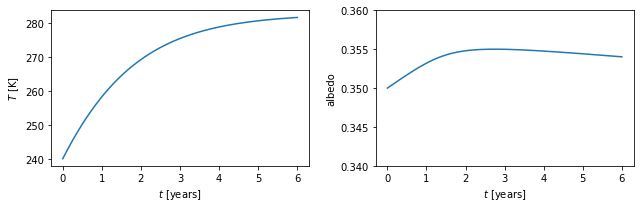

In [24]:
plt.figure(1, figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(timepoints, Temperature)
plt.xlabel('$t$ [years]')
plt.ylabel('$T$ [K]')

plt.subplot(1, 2, 2)
plt.plot(timepoints, Albedo)
plt.xlabel('$t$ [years]')
plt.ylabel('albedo')
plt.ylim([0.34,0.36])

plt.tight_layout()

For a graphical approach to steady-state solutions, use $a_\text{eq}(T)$ and compare fluxes.

In [7]:
# Calculate albedo and radiation for given tempeature range (no stochastic noise)

albedo_func = AlbedoEq(temperature_range)
rad_incoming = IncomingRad(albedo_func)
rad_outgoing = OutgoingRad(temperature_range)
rad_diff = rad_incoming - rad_outgoing

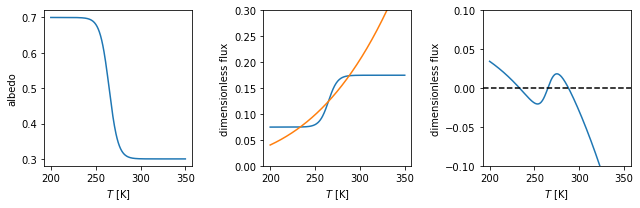

In [8]:
plt.figure(1, figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.plot(temperature_range, albedo_func)
plt.ylabel('albedo')
plt.xlabel('$T$ [K]')

plt.subplot(1, 3, 2)
plt.plot(temperature_range, rad_incoming)
plt.plot(temperature_range, rad_outgoing)
plt.xlabel('$T$ [K]')
plt.ylabel('dimensionless flux')
plt.ylim([0,0.3])

plt.subplot(1, 3, 3)
plt.plot(temperature_range, rad_diff)
#plt.plot(temperature_range, np.zeros(temperature_range))
plt.axhline(y=0,ls='--',c='k')
plt.xlabel('$T$ [K]')
plt.ylabel('dimensionless flux')
plt.ylim([-0.1,0.1])

plt.tight_layout()

### Find the fixed points
To find the fixed points, you can use `fsolve` to find the roots (*i.e.*, the zero crossings of $\text{d}T/\text{d}t$).  Choose the starting guess closer to the root you're interested in to get the value (The plots are useful for this!).

In [9]:
def flux_diff(T):
    return IncomingRad(AlbedoEq(T)) - OutgoingRad(T)

fixedpt = fsolve(flux_diff,220.0)    # T = 220 is a starting guess
print("T = %.2f K" %fixedpt)

T = 233.52 K


# The climate system with fluctuations
Although a fixed point may be stable in deterministic setting, the addition of fluctuations or noise may push the system significantly out of equilibrium.  Let's examine the robustness of the fixed points to noise perturbations.

With the addition of noise, an Ordinary Differential Equation (ODE) becomes a Stochastic Differential Equation (SDE), and unfortunately the solution methods become more subtle.  For our purposes, it will suffice to solve our SDE numerical with a simple forward-Euler timestepping approximation, wherein noise is added at each time step.  This *Euler–Maruyama method* entails one additional subtlety, which is that the noise term much be appropriately scaled to produce the desired variance in the solution.  In paricular, the noise is scaled by the *square root* of the time step: $\text{d(noise)} = \eta\,\sqrt{\text{d}t}$.

In [10]:
# Noise parameters
# These should equate to the variance in the overal noise distribution
eta_T = 5
eta_a = 0.01

Let's do an ensemble of noisey simulations over a long timescale.

In [32]:
# Define time span for simulations

num_sims = 1000 # number of runs

time_init = 0
time_end = 1000
NumStep = 1000 # number of time steps
dt = float(time_end - time_init) / NumStep # time step

ts = np.arange(time_init, time_end, dt)
Tstoc = np.zeros((num_sims,NumStep))    # initialize T
Astoc = np.zeros((num_sims,NumStep))    # initialize a

T_init = 280
a_init = 0.35

Tstoc[:,0] = T_init
Astoc[:,0] = a_init

# Noise function
def dW(delta_t): 
    """Sample a random number at each call."""
    return np.random.normal(loc = 0.0, scale = np.sqrt(delta_t)) # scale variance by time step

In [33]:
# Euler–Maruyama method
for k in range(num_sims):
    for i in range(1, ts.size):
        t = (i-1) * dt
        T = Tstoc[k,i-1]
        a = Astoc[k,i-1]
        Tstoc[k,i] = T + dT_dt(T, a)*dt + eta_T * dW(dt)
        Astoc[k,i] = a + da_dt(T, a)*dt + eta_a * dW(dt)

Take a look at a few realizations:

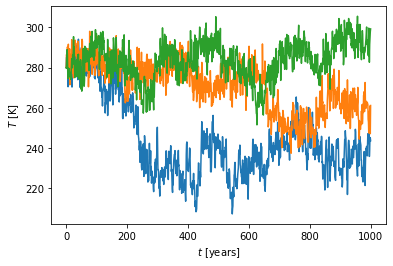

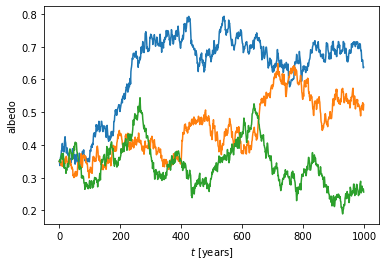

In [34]:
rng = np.random.default_rng()
ran = rng.integers(0, num_sims, 3)
for k in ran:
    plt.plot(ts, Tstoc[k,:])
    plt.xlabel('$t$ [years]')
    plt.ylabel('$T$ [K]')
plt.show()
    
for k in ran:
    plt.plot(ts, Astoc[k,:])
    plt.xlabel('$t$ [years]')
    plt.ylabel('albedo')
    #plt.ylim([0.3,0.5])
plt.show()

## Observations
#### Does anything stand out to you? What do you notice and what do you wonder about?
Play around with the values—initial conditions, noise magnitude, etc.

## Statistics
At the end of each run, in what state is the climate system?  What is the overall distribution?  

In [35]:
Tends = Tstoc[:,-1]

A histogram should reveal information about the distribution.  What do you see?  And how do you interpret the shape—what's similar; what's different; can you interpret the results?

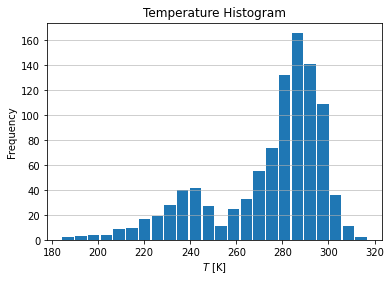

In [36]:
n, bins, patches = plt.hist(x=Tends, bins='auto', color='C0', rwidth=0.90)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('$T$ [K]')
plt.ylabel('Frequency')
plt.title('Temperature Histogram')
plt.show()

What if instead of taking the final temperature values, we take the overall average temperature over each run seperately?  That is, we look at the global temperature history for each run, aggregate it with an average, and compare to many "possible histories."

In [37]:
std_list = np.zeros(num_sims)
mean_list = np.zeros(num_sims)

for k in range(num_sims):
    std_list[k] = np.std(Tstoc[k,:])
    
for k in range(num_sims):
    mean_list[k] = np.mean(Tstoc[k,:])

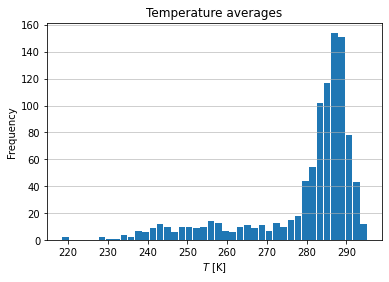

In [38]:
n, bins, patches = plt.hist(x=mean_list, bins='auto', color='C0', rwidth=0.90)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('$T$ [K]')
plt.ylabel('Frequency')
plt.title('Temperature averages')
plt.show()

## Observations
#### Does anything stand out to you? What do you notice and what do you wonder about?
Again, play around with the values—initial conditions, noise magnitude, etc. to see how things change.

Interpret your results in terms of the climate system.  

What about the sensitivity of the climate fixed points?  According to the data, how much variance is associated with each "stable" state?  How does the variance of each state compare to each other?  To get a meaningful comparison, you may wish to use the calculate the Coefficient of Variation (CoV) for an appropriate neighborhood of each peak.

Below is an alternative calculation in which the overall CoV is calculated for each run, and the distribution of CoV is displayed.  What does this plot tell us?

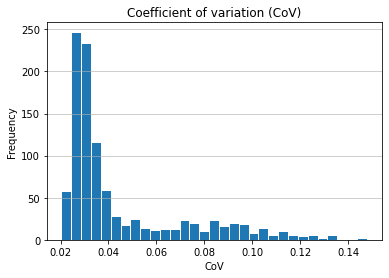

In [39]:
n, bins, patches = plt.hist(x=std_list/mean_list, bins='auto', color='C0', rwidth=0.90)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('CoV')
plt.ylabel('Frequency')
plt.title('Coefficient of variation (CoV)')
plt.show()